This notebook is a simplified version of the `Smoothing Objective Function All Metrics.ipynb` notebook. It is intended to be a starting point for those who want to understand the smoothing objective function and how it can be used to optimise the predictions of a model.

In [16]:
%reload_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ipywidgets as widgets
from ipywidgets import interact
import seaborn as sns
from datetime import datetime
from utils.neural_network import train_nn, get_device, batch_data_by_country

from utils.load_data import load_data, load_gt_data
from utils.preprocessing_v2 import Preprocessing, get_gt_diff_logs
import utils.results as results
import torch
import torch.nn as nn
from tqdm.notebook import tqdm

TRENDS_FOLDER = 'data/google_trends/'
GDP_FOLDER = 'data/gdp/'
DATA_PREFIX = 'trends_data_by_topic_'

EPS = 1e-15
SEED = 42

## Loading and Preprocessing Data

### Loading Google Trends

In [17]:
TRAIN_PROPORTION = 0.9
MODE = "pct" # None | "pct" | "diff"
PERIOD = 4  # Year to year prediction
device = get_device()

In [18]:
data, all_gdps, all_gts = load_data()
data['country'].unique()

array(['Switzerland', 'Germany', 'United Kingdom', 'Japan', 'Canada',
       'Korea', 'United States'], dtype=object)

In [19]:
preprocessor = Preprocessing(epsilon=EPS, gdp_diff_period=PERIOD, all_GDPs=all_gdps, all_GTs=all_gts)

X_train, y_train, X_valid, y_valid, x_hf = preprocessor.preprocess_data(train_pct=TRAIN_PROPORTION, 
                                                                  mode="diff", 
                                                                  take_log_diff_gdp=True,
                                                                  gt_trend_removal=False, 
                                                                  keep_pca_components=180, 
                                                                  noisy_data_stds=[0.005, 0.05, 0.1], 
                                                                  add_encoded_month=False, 
                                                                  gt_data_transformations=[get_gt_diff_logs], other_params={'plot_pca': False})

x_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
x_valid_t = torch.tensor(X_valid, dtype=torch.float32).to(device)
y_valid_t = torch.tensor(y_valid, dtype=torch.float32).to(device)
x_hf_t = torch.tensor(x_hf, dtype=torch.float32).to(device)

print(all_gts['country'].unique())

X_train shape : (1780, 180)
X_valid shape : (53, 180)
y_train shape : (1780,)
y_valid shape : (53,)
X_high_freq shape : (1547, 180)
['Switzerland' 'Germany' 'United Kingdom' 'Japan' 'Canada' 'Korea'
 'United States']


## Smoothing Model

In [20]:
preprocessor.dates_high_freq
preprocessor.country_high_freq

df_hf = pd.DataFrame({
    'date': preprocessor.dates_high_freq,
    'country': preprocessor.country_high_freq,
    'data': [x_hf[i] for i in range(len(x_hf))]
})

df_x_train = pd.DataFrame({
    'date': preprocessor.dates_train.copy(),
    'country': preprocessor.country_train.copy(),
    'data': [X_train[i].copy() for i in range(len(X_train))],
    'y_true': [y_train[i].copy() for i in range(len(y_train))]
})

df_hf['date'] = pd.to_datetime(df_hf['date'])
df_x_train['date'] = pd.to_datetime(df_x_train['date'])

In [29]:
from torch.nn import MSELoss

def _compute_smoothness_loss(y_pred, smoothness_weight_ord1=0.33, smoothness_weight_ord2=0.33):
    if y_pred.shape[1] > 1:
        # Compute the loss related to smoothness
        smoothness_loss_ord1 = 0
        for i in range(1, 4):
            # Divide by 3 because dt is 1/3 month, and by 4 because we have 4 time points and we average them
            smoothness_loss_ord1 += torch.linalg.norm((y_pred[:, i, :] - y_pred[:, i - 1, :])) ** 2 / (3 * 4 * y_pred.shape[0])

        # Constraint on the double derivative
        smoothness_loss_ord2 = 0
        for i in range(2, 4):
            smoothness_loss_ord2 += torch.linalg.norm(y_pred[:, i, :] - 2 * y_pred[:, i - 1, :] + y_pred[:, i - 2, :]) ** 2 / (3 * 4 * y_pred.shape[0])

        return smoothness_loss_ord1 * smoothness_weight_ord1 + smoothness_loss_ord2 * smoothness_weight_ord2

    else:
        raise ValueError("Input shape not supported!")

def custom_loss(y_pred, y_true, smoothness_weight_ord1=0.33, smoothness_weight_ord2=0.33):
    # Compute usual MSE on actual GDP values
    mse = MSELoss()

    if y_pred.shape[1] > 1:
        prediction_loss = mse(y_pred[:, -1, :], y_true)  # First column is the actual GDP

        smooth_loss = _compute_smoothness_loss(y_pred, smoothness_weight_ord1, smoothness_weight_ord2)

        return prediction_loss + smooth_loss
    elif y_pred.shape[1] == 1:
        return mse(y_pred, y_true)
    else:
        raise ValueError("Input shape not supported!")

In [22]:
augmented_data, filtered_countries, filtered_dates, y_augmented_train, _ = batch_data_by_country(df_x_train, 
                                                                                              df_hf, 
                                                                                              3, 
                                                                                              0, 
                                                                                              ['y_true'], 
                                                                                              False)

y_augmented_train = np.array(y_augmented_train).squeeze().astype(np.float32)

In [24]:
from joblib import Parallel, delayed

ord1_smoothness_weights = np.logspace(-1, 2, 30)
ord2_smoothness_weights = np.logspace(1, 3, 30)

def train_and_evaluate(ord1_weight, ord2_weight):
    model, training_loss, validation_loss, validation_r_squared, mse_loss = train_nn(
        augmented_data,
        y_augmented_train,
        X_valid,
        y_valid,
        num_epochs=100,
        learning_rate=1e-4,
        weight_decay=1e-2,
        verbose=False,
        custom_loss=lambda x, y: custom_loss(x, y, ord1_weight, smoothness_weight_ord2=ord2_weight),
        current_gdp_idx=-1,
        seed=SEED,
    )
    y_pred_hf = model(torch.tensor(x_hf, dtype=torch.float32).to(device)).clone().detach().cpu().numpy().squeeze()
    smoothness_loss = results.measure_smoothness(y_pred_hf, preprocessor.dates_high_freq, preprocessor.country_high_freq)

    return (ord1_weight, ord2_weight, training_loss, validation_loss, validation_r_squared, mse_loss, smoothness_loss)

# Run in parallel
param_combinations = [(ord1, ord2) for ord1 in ord1_smoothness_weights for ord2 in ord2_smoothness_weights]

results_ord12 = Parallel(n_jobs=-1, backend='loky')(
    delayed(train_and_evaluate)(ord1, ord2) for ord1, ord2 in tqdm(param_combinations)
)

# Unpack results
ord1_weight, ord2_weight, training_loss, validation_loss, validation_r_squared, mse_loss, smoothness_loss = zip(*results_ord12)


  0%|          | 0/900 [00:00<?, ?it/s]

In [25]:
ord1_weight, ord2_weight, training_loss, validation_loss, validation_r_squared, mse_loss, smoothness_loss = zip(*results_ord12)

In [26]:
def plot_heatmap_top_filtered_percent(data, x_vals, y_vals, title, xlabel, ylabel, cmap='viridis', threshold=5):
    # Compute the 90th percentile threshold
    valid_data = data[np.isfinite(data)]
    if len(valid_data) == 0:
        print("No valid data to plot.")
        return
    #threshold = np.percentile(valid_data, 90)
    
    # Mask values below the threshold
    data_filtered = np.where((data >= -threshold) & (data <= threshold), data, np.nan)
    
    im = plt.imshow(data_filtered, origin='lower', 
                    extent=[min(x_vals), max(x_vals), min(y_vals), max(y_vals)], 
                    aspect='auto', cmap=cmap) #, norm=norm)
    
    # Hilight the maximum value
    max_val = np.nanmax(data_filtered)
    max_idx = np.where(data_filtered == max_val)

    cbar = plt.colorbar(im)
    cbar.set_label('Metric Value')
    plt.title(title + f' (Between -{threshold} and {threshold})')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xscale('log')
    plt.yscale('log')


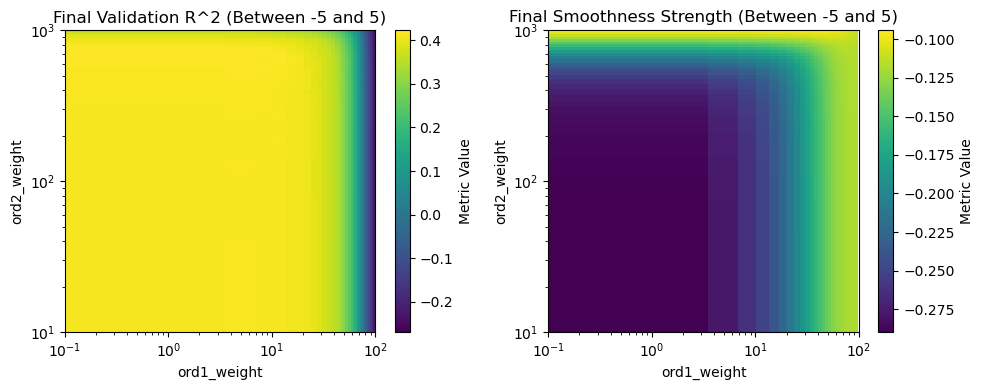

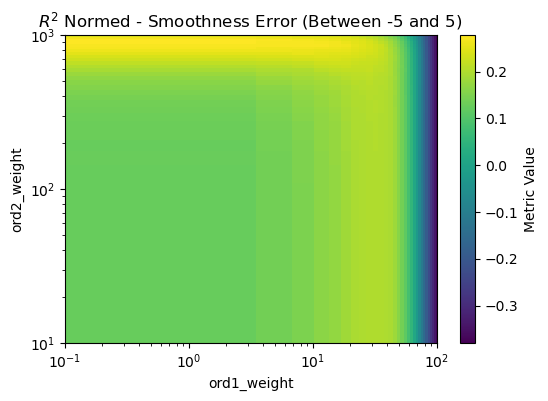

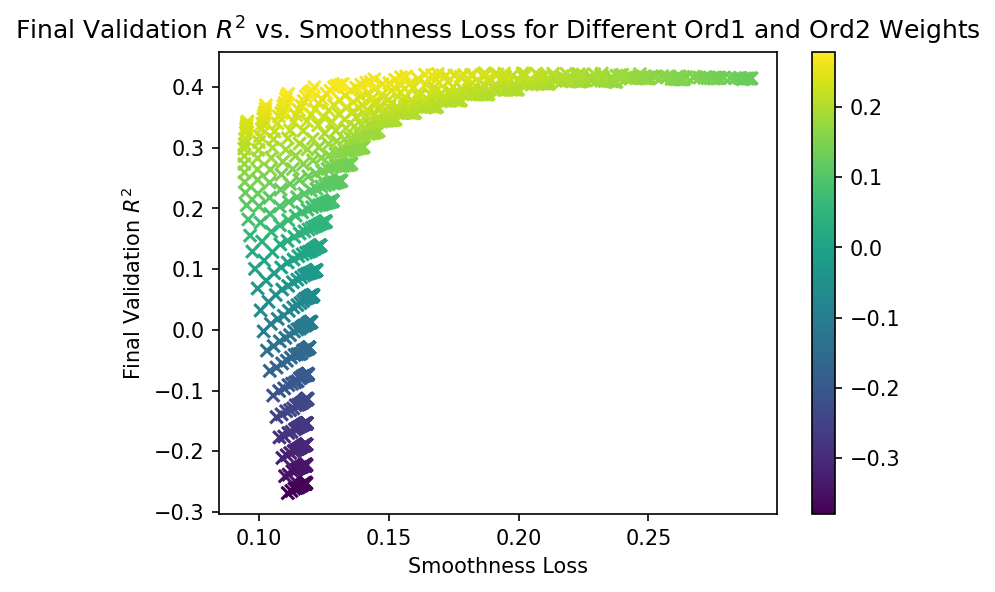

(48.93900918477494, 10.0)

In [27]:
N1 = len(ord1_smoothness_weights)
N2 = len(ord2_smoothness_weights)

# Create mapping from (ord1_weight, ord2_weight) to grid indices
ord1_to_idx = {w: i for i, w in enumerate(ord1_smoothness_weights)}
ord2_to_idx = {w: i for i, w in enumerate(ord2_smoothness_weights)}

# Initialize empty arrays for final metrics
final_train_loss = np.zeros((N1, N2))
final_val_loss = np.zeros((N1, N2))
final_val_r2 = np.zeros((N1, N2))
final_smoothness_mean = np.zeros((N1, N2))
final_validation_mse_loss = np.zeros((N1, N2))  # example if needed
final_training_mse_loss = np.zeros((N1, N2))  # example if needed

for ord1, ord2, tr_loss, val_loss, val_r2, mse_loss, sm_loss in zip(ord1_weight, ord2_weight, training_loss, validation_loss, validation_r_squared, mse_loss, smoothness_loss):
    i = ord1_to_idx[ord1]
    j = ord2_to_idx[ord2]

    final_train_loss[i, j] = tr_loss[-1] if len(tr_loss) > 0 else np.nan
    final_val_loss[i, j] = val_loss[-1] if len(val_loss) > 0 else np.nan
    final_val_r2[i, j] = val_r2[-1] if len(val_r2) > 0 else np.nan
    
    final_smoothness_mean[i, j] = sm_loss[1] if len(sm_loss) > 0 else np.nan
    # final_validation_mse_loss[i, j] = mse_loss[-1][1] if len(mse_loss) > 0 else np.nan
    # final_training_mse_loss[i, j] = mse_loss[-1][0] if len(mse_loss) > 0 else np.nan

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plot_heatmap_top_filtered_percent(final_val_r2, ord1_smoothness_weights, ord2_smoothness_weights, 
             title='Final Validation R^2', 
             xlabel='ord1_weight', 
             ylabel='ord2_weight')

# Plot final smoothness mean metric
plt.subplot(1, 2, 2)
plot_heatmap_top_filtered_percent(-final_smoothness_mean, ord1_smoothness_weights, ord2_smoothness_weights, 
             title='Final Smoothness Strength', 
             xlabel='ord1_weight', 
             ylabel='ord2_weight')
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
normed_final_val_r2 = final_val_r2 - np.nanmin(final_val_r2) / (np.nanmax(final_val_r2) - np.nanmin(final_val_r2))
normed_final_smoothness_mean = final_smoothness_mean - np.nanmin(final_smoothness_mean) / (np.nanmax(final_smoothness_mean) - np.nanmin(final_smoothness_mean))
plot_heatmap_top_filtered_percent(final_val_r2-final_smoothness_mean, ord1_smoothness_weights, ord2_smoothness_weights, 
             title='$R^2$ Normed - Smoothness Error', 
             xlabel='ord1_weight', 
             ylabel='ord2_weight')
plt.show()

# Plot R^2 over the smoothness strength scatter plot for all values
plt.figure(figsize=(6, 4), dpi=150)
plt.scatter(final_smoothness_mean.flatten(), final_val_r2.flatten(), c=(final_val_r2-final_smoothness_mean).flatten(), cmap='viridis', marker='x')
plt.colorbar()
plt.xlabel('Smoothness Loss')
plt.ylabel('Final Validation $R^2$')
plt.title('Final Validation $R^2$ vs. Smoothness Loss for Different Ord1 and Ord2 Weights')
plt.show()
np.nanmax(final_val_r2-final_smoothness_mean), np.unravel_index(np.nanargmax(final_val_r2-final_smoothness_mean), final_val_r2.shape)
idxs = np.unravel_index(np.nanargmax(final_val_r2-final_smoothness_mean), final_val_r2.shape)
best_ord1 = ord1_smoothness_weights[idxs[0]]
best_ord2 = ord2_smoothness_weights[idxs[1]]

best_ord1, best_ord2

Using cuda device


100%|██████████| 100/100 [00:01<00:00, 78.49it/s]


Final training loss: 0.3424457907676697
Final validation loss: 0.43573638796806335
Final validation R^2: 0.42077457170289945


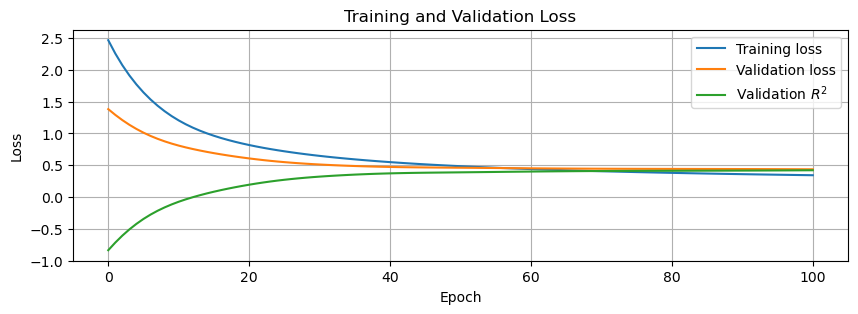

[0.011580969043636105, 0.09067216009463903]

In [30]:
# smoothness_weight_ord1=5
# smoothness_weight_ord2=10
smoothness_weight_ord1=5
smoothness_weight_ord2=10
smooth_model, _, _, _, global_mse_losses = train_nn(augmented_data, 
                                                    y_augmented_train, 
                                                    X_valid, 
                                                    y_valid, 
                                                    num_epochs=100, 
                                                    learning_rate=1e-4, 
                                                    weight_decay=1e-2, 
                                                    verbose=True,
                                                    current_gdp_idx=-1,
                                                    custom_loss=lambda x, y: custom_loss(x, y, smoothness_weight_ord1, smoothness_weight_ord2),
                                                    seed=SEED)
global_mse_losses[-1]

In [31]:
device = get_device(False)

# Get the predictions
y_pred = smooth_model(x_valid_t).clone().detach().cpu().numpy().squeeze()
y_pred_train = smooth_model(x_train_t).clone().detach().cpu().numpy().squeeze()
y_pred_hf = smooth_model(x_hf_t).clone().detach().cpu().numpy().squeeze()

In [32]:
df_hf_squeezed = {
    'date': preprocessor.dates_high_freq,
    'country': preprocessor.country_high_freq,
    'data': x_hf_t.clone().detach().cpu().numpy().squeeze(),
}


In [33]:
train_fn = lambda seed: train_nn(X_train, y_train, X_valid, y_valid, num_epochs=100, learning_rate=1e-4, weight_decay=1e-2, verbose=False, seed=seed)
bootstrapped_results = results.bootstrap_ensemble(X_valid, y_valid, train_fn, n_ensembling=100, seed=SEED, device=get_device(False), other_pred_set=df_hf_squeezed)

rsquared_ensemble = bootstrapped_results['rsquared_ensemble']
smoothness_ensemble = bootstrapped_results['other_pred_smoothness']

print("Basic Model R^2 Median: ", np.median(rsquared_ensemble))
print("Basic Model Smoothness Median: ", np.median(smoothness_ensemble))

Bootstrapping Ensembling: 100%|██████████| 100/100 [00:33<00:00,  2.95it/s]

Basic Model R^2 Median:  0.13725862191605903
Basic Model Smoothness Median:  0.6552307970220265


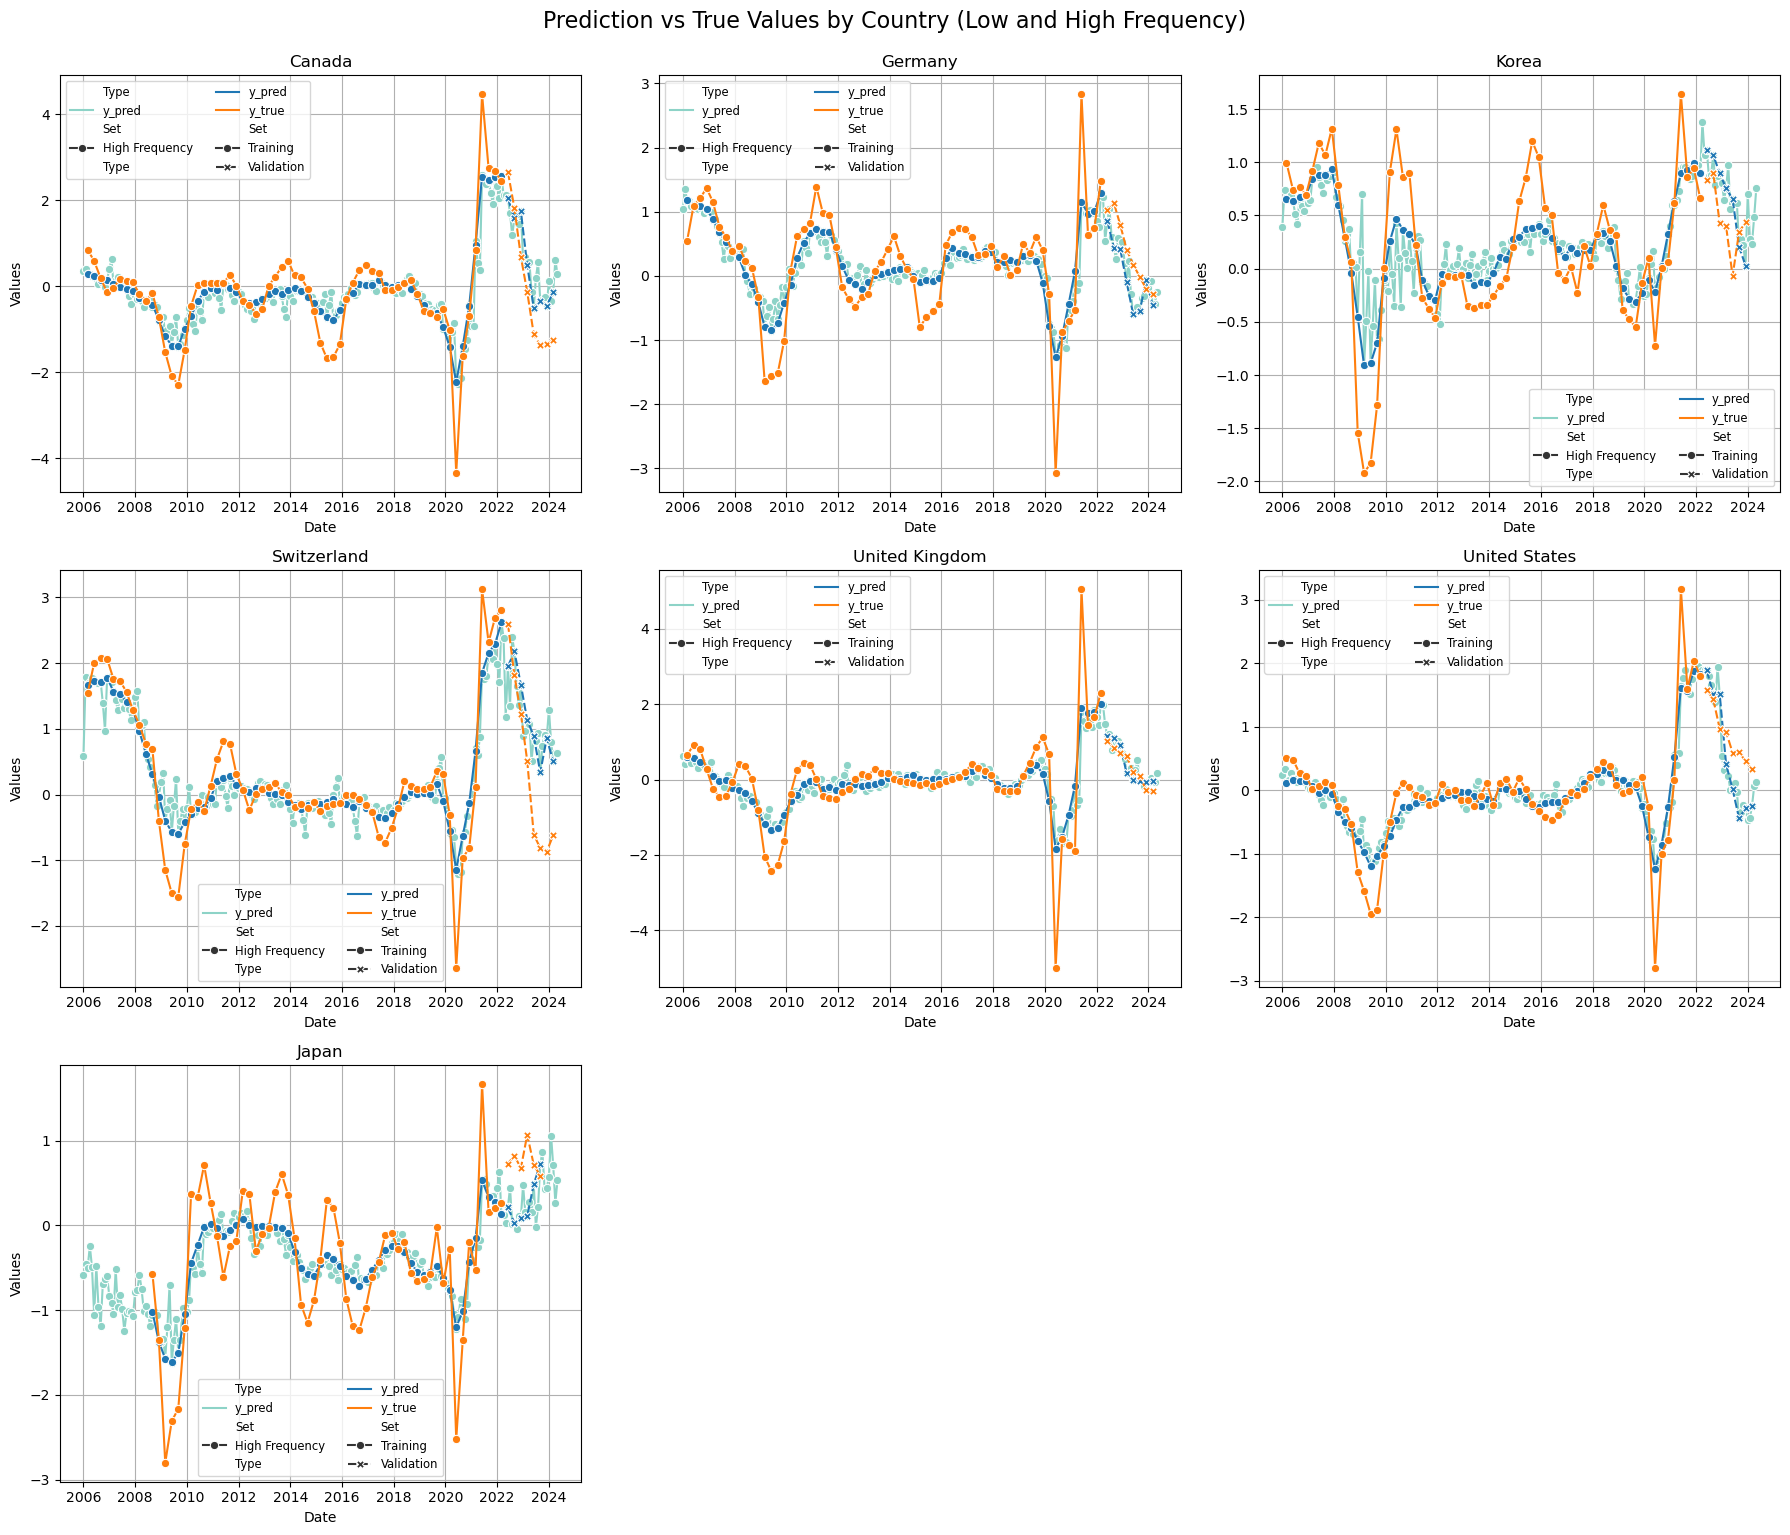

In [48]:
# Associate the result by country and add 'Set' column
y_pred_country = pd.DataFrame({
    'date': preprocessor.dates_valid,
    'country': preprocessor.country_valid,
    'y_pred': y_pred,
    'y_true': y_valid,
    'Set': 'Validation'
})

y_pred_train_country = pd.DataFrame({
    'date': preprocessor.dates_train,
    'country': preprocessor.country_train,
    'y_pred': y_pred_train,
    'y_true': y_train,
    'Set': 'Training'
})

# Put together the train and the validation set
predictions = pd.concat([y_pred_train_country, y_pred_country])
predictions_hf = pd.DataFrame({
    'date': preprocessor.dates_high_freq,
    'country': preprocessor.country_high_freq,
    'y_pred': y_pred_hf,
    'Set': 'High Frequency'
})


# Melting the dataframe for better plotting
predictions_melted = predictions.melt(
    id_vars=["date", "country", "Set"],
    value_vars=["y_pred", "y_true"], 
    var_name="Type", value_name="Value"
)

predictions_hf_melted = predictions_hf.melt(
    id_vars=["date", "country", "Set"],
    value_vars=["y_pred"], 
    var_name="Type", value_name="Value"
)

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

plt.rcdefaults()

# Combine train and validation set
predictions = pd.concat([y_pred_train_country, y_pred_country])

# Melt the dataframes for better plotting
predictions_melted = predictions.melt(
    id_vars=["date", "country", "Set"],
    value_vars=["y_pred", "y_true"], 
    var_name="Type", value_name="Value"
)

predictions_hf_melted = predictions_hf.melt(
    id_vars=["date", "country", "Set"],
    value_vars=["y_pred"], 
    var_name="Type", value_name="Value"
)

# Unique list of countries
countries = predictions["country"].unique()

# Determine grid size for subplots
num_countries = len(countries)
cols = 3  # Number of columns in subplot grid
rows = -(-num_countries // cols)  # Ceiling division for rows

# Create the figure and axes for subplots
fig, axes = plt.subplots(rows, cols, figsize=(18, rows * 5))
axes = axes.flatten()  # Flatten axes for easier indexing

# Loop through each country to plot
for idx, country in enumerate(countries):
    ax = axes[idx]  # Current subplot
    
    # Filter data for the current country
    filtered_data = predictions_melted[predictions_melted["country"] == country]
    filtered_data_hf = predictions_hf_melted[predictions_hf_melted["country"] == country]
    
    # Plot high-frequency data
    sns.lineplot(
        data=filtered_data_hf,
        x="date", y="Value", hue="Type", style="Set",
        errorbar=None, markers=True, ax=ax, palette="Set3"
    )
    
    # Plot low-frequency data (training/validation)
    sns.lineplot(
        data=filtered_data,
        x="date", y="Value", hue="Type", style="Set",
        errorbar=None, markers=True, ax=ax
    )

    # Subplot title and formatting
    ax.set_title(f"{country}")
    ax.set_xlabel("Date")
    ax.set_ylabel("Values")
    ax.grid(True)
    ax.legend(loc="best", fontsize="small", ncol=2)

# Remove unused axes (if any)
for i in range(len(countries), len(axes)):
    fig.delaxes(axes[i])

# Adjust layout and main title
plt.tight_layout()
plt.suptitle("Prediction vs True Values by Country (Low and High Frequency)", fontsize=16, y=1.02)
plt.show()


## Mesure smoothness

Using cuda device


100%|██████████| 100/100 [00:00<00:00, 235.19it/s]


Final training loss: 0.01687396503984928
Final validation loss: 0.5011449456214905
Final validation R^2: 0.3338268707359172


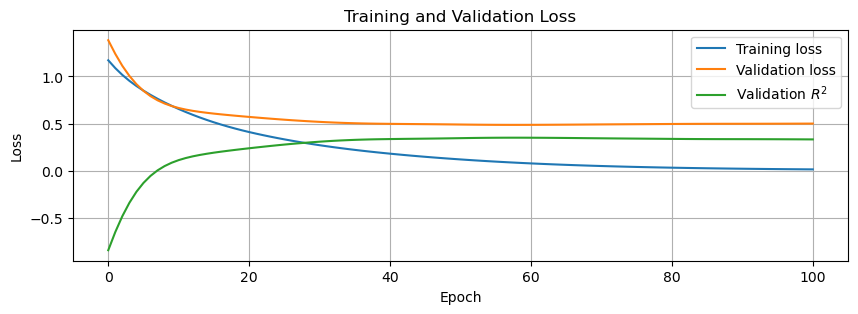

Basic R2 score: 0.3338268707359172
Adjusted R2 score: 0.42077457170289945


In [35]:
basic_model, basic_training_loss, basic_validation_loss, basic_validation_r_squared, basic_global_mse_losses = train_nn(X_train, 
                                                                        y_train, 
                                                                        X_valid, 
                                                                        y_valid, 
                                                                        num_epochs=100, 
                                                                        learning_rate=1e-4, 
                                                                        weight_decay=1e-2, 
                                                                        verbose=True,
                                                                        seed=SEED)

# Get the predictions
basic_y_pred_hf = basic_model(torch.tensor(x_hf, dtype=torch.float32).to(device)).clone().detach().cpu().numpy().squeeze()
basic_r2_score = results.r2_score(y_valid, basic_model(x_valid_t).clone().detach().cpu().numpy().squeeze())

# R2 on hf
adjusted_r2_score = results.r2_score(y_valid, smooth_model(x_valid_t).clone().detach().cpu().numpy().squeeze())

print(f"Basic R2 score: {basic_r2_score}")
print(f"Adjusted R2 score: {adjusted_r2_score}")

In [36]:
train_fn = lambda seed: train_nn(augmented_data, y_augmented_train, X_valid, y_valid, num_epochs=100, learning_rate=1e-4, weight_decay=1e-2, verbose=False, seed=seed, custom_loss=lambda x, y: custom_loss(x, y, smoothness_weight_ord1, smoothness_weight_ord2))
smooth_bootstrapped_results = results.bootstrap_ensemble(X_valid, y_valid, train_fn, n_ensembling=100, seed=SEED, device=get_device(False), other_pred_set=df_hf_squeezed)

smooth_rsquared_ensemble = smooth_bootstrapped_results['rsquared_ensemble']
smooth_smoothness_ensemble = smooth_bootstrapped_results['other_pred_smoothness']

print("Smooth Model R^2 Median: ", np.median(smooth_rsquared_ensemble))
print("Smooth Model Smoothness Median: ", np.median(smooth_smoothness_ensemble))

print("Basic Model R^2 Median: ", np.median(rsquared_ensemble))
print("Basic Model Smoothness Median: ", np.median(smoothness_ensemble))

Bootstrapping Ensembling: 100%|██████████| 100/100 [01:26<00:00,  1.16it/s]

Smooth Model R^2 Median:  0.2707538936758459
Smooth Model Smoothness Median:  0.2186800020699904
Basic Model R^2 Median:  0.13725862191605903
Basic Model Smoothness Median:  0.6552307970220265
